In [32]:
import torch
from torch.autograd import Variable
print(f'Pytorch version {torch.__version__}')

import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import distributions

from time import time
import re
import json

import os
import sys
import itertools
sys.path.append('/Users/ioanaciuca/Desktop/Normalizing_flows/DeepSpectra/')

import torch.optim as optim

from nflib.spline_flows import NSF_CL
from nflib.flows import (
    AffineConstantFlow,
    ActNorm,
    Invertible1x1Conv,
    NormalizingFlow,
    NormalizingFlowModel,
)

device='cpu'


import random

random.seed(0)

%matplotlib inline

Pytorch version 1.7.1


In [33]:
df = pd.read_csv("/Users/ioanaciuca/Desktop/hephaestusaiLight/cache/Lissitzky/Reduced_l_scattering_fixed_pix_0_25mm10_4_2048_df_rgb0.csv")
df.head(10)

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54,target_names,class_labels,img_names
0,0.051830,0.082382,0.104085,0.128972,0.174603,0.242199,0.312489,0.462538,0.614216,0.692868,...,0.068220,0.072649,0.085590,0.087186,0.118635,0.130939,0.142368,Lissitzky,0,interp_Lissitzky_11
1,0.102552,0.155601,0.214677,0.251556,0.214186,0.210915,0.291698,0.426530,0.593897,0.558101,...,0.049866,0.066253,0.072236,0.067197,0.092788,0.090560,0.106177,Lissitzky,0,interp_Lissitzky_13
2,0.090540,0.138456,0.142635,0.149612,0.200326,0.305960,0.477229,0.681638,0.778879,0.622674,...,0.070910,0.110416,0.121850,0.113016,0.148502,0.150528,0.128316,Lissitzky,0,interp_Lissitzky_15
3,0.031086,0.058972,0.081662,0.095281,0.140449,0.234375,0.383631,0.546570,0.659464,0.828849,...,0.045668,0.086153,0.091347,0.072775,0.108582,0.095929,0.108382,Not_Lissitzky,1,interp_Fake_01
4,0.027554,0.050333,0.077188,0.111440,0.175817,0.287615,0.436760,0.595772,0.715857,0.726890,...,0.047902,0.098938,0.097463,0.070780,0.111246,0.092723,0.105416,Not_Lissitzky,1,interp_Fake_02
5,0.328366,0.207748,0.150963,0.154799,0.211627,0.330365,0.498907,0.633655,0.644361,0.590730,...,0.049452,0.097010,0.097045,0.080643,0.107908,0.083371,0.084840,Lissitzky,0,interp_Lissitzky_02
6,0.085221,0.155161,0.187690,0.173021,0.192470,0.255707,0.356479,0.445215,0.501458,0.557126,...,0.048678,0.084122,0.089594,0.073891,0.092073,0.079697,0.076428,Lissitzky,0,interp_Lissitzky_07
7,0.076145,0.103794,0.111488,0.129938,0.178964,0.265859,0.398020,0.583669,0.631342,0.580787,...,0.055222,0.096271,0.104015,0.095561,0.133765,0.148918,0.131161,Lissitzky,0,interp_Lissitzky_08
8,0.358972,0.239302,0.168673,0.148320,0.164443,0.223885,0.321329,0.431254,0.610010,0.845281,...,0.059159,0.081039,0.096831,0.094377,0.115337,0.128008,0.164050,Lissitzky,0,interp_Lissitzky_19
9,0.056081,0.087196,0.109166,0.129710,0.163686,0.215699,0.302339,0.434211,0.512461,0.690737,...,0.058885,0.075630,0.085848,0.087602,0.116731,0.126653,0.124386,Lissitzky,0,interp_Lissitzky_14


In [34]:
len(df)

22

In [35]:
df_features = df.copy()
df_features = df_features.drop(['class_labels', 'target_names', 'img_names'], axis=1)
df_features.describe()


,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_45,Coeff_46,Coeff_47,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.095158,0.104193,0.107508,0.118375,0.153338,0.228457,0.354350,0.517720,0.662197,0.707838,...,0.055806,0.060961,0.058591,0.049856,0.085633,0.092806,0.081878,0.117283,0.116736,0.130457
std,0.088346,0.051573,0.042265,0.041557,0.037499,0.051771,0.077490,0.095024,0.097525,0.120059,...,0.012300,0.011551,0.010350,0.010176,0.013790,0.015498,0.015238,0.017127,0.022551,0.027720
min,0.024856,0.040095,0.052713,0.062724,0.088835,0.146825,0.234549,0.385064,0.501458,0.557126,...,0.036185,0.039691,0.039061,0.032785,0.061698,0.068049,0.057573,0.090745,0.079697,0.076428
25%,0.045534,0.064481,0.078535,0.090809,0.122559,0.198332,0.304877,0.436962,0.597925,0.596773,...,0.049400,0.054836,0.051545,0.042234,0.075764,0.080649,0.070840,0.108076,0.093798,0.109308
50%,0.065469,0.094857,0.101616,0.113115,0.159204,0.229118,0.352870,0.495201,0.650279,0.692999,...,0.053743,0.061111,0.057465,0.049659,0.083969,0.091884,0.082881,0.116034,0.125417,0.129738
75%,0.099549,0.131136,0.112989,0.130547,0.178177,0.259226,0.397037,0.582876,0.720097,0.808047,...,0.062515,0.068247,0.065914,0.055926,0.096825,0.098620,0.093579,0.127351,0.132333,0.145804
max,0.358972,0.239302,0.214677,0.251556,0.214186,0.330365,0.498907,0.719860,0.851778,0.958867,...,0.080321,0.085157,0.078972,0.070910,0.110416,0.129249,0.113016,0.154919,0.150528,0.193708


In [36]:
df_fake= df[df['class_labels'] == 1]
df_fake

df_artist = df[df['class_labels'] == 0]
df_artist

feat_data_fake = df_fake.drop(['class_labels', 'target_names', 'img_names'], axis=1)
feat_data_artist = df_artist.drop(['class_labels', 'target_names', 'img_names'], axis=1)

data_fake = feat_data_fake.to_numpy()
data_artist = feat_data_artist.to_numpy()

In [44]:
df_fake

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54,target_names,class_labels,img_names
3,0.031086,0.058972,0.081662,0.095281,0.140449,0.234375,0.383631,0.546570,0.659464,0.828849,...,0.045668,0.086153,0.091347,0.072775,0.108582,0.095929,0.108382,Not_Lissitzky,1,interp_Fake_01
4,0.027554,0.050333,0.077188,0.111440,0.175817,0.287615,0.436760,0.595772,0.715857,0.726890,...,0.047902,0.098938,0.097463,0.070780,0.111246,0.092723,0.105416,Not_Lissitzky,1,interp_Fake_02


In [38]:
len(df_artist)
len(df_fake)

2

In [9]:
def get_train_test_data(df):

    target = df.class_labels.to_numpy()  # class labels

    target_names = df.target_names.to_list()  # name
    feat_data = df.drop(["class_labels", "target_names", "img_names"], axis=1)
    feature_names = feat_data.columns.to_list()

    data = feat_data.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        data,
        target,
        test_size=0.3,
        random_state=0,
    )
    print("Training records: {}".format(X_train.shape[0]))
    print("Testing records: {}".format(X_test.shape[0]))



    return X_train, y_train, X_test, y_train


In [ ]:
X_train_artist, y_train_artist, X_test_artist, y_test_artist = get_train_test_data(df_artist)

In [ ]:
X = np.log10(X_train_artist[:, :-1])

X = torch.Tensor(X)
print(X.shape)

dim = X.shape[-1]
print('New dim after adding the labels is', dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 1
hidden_dim = 16 #50 dims here... probs neeed to increase


flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

#if torch.cuda.device_count() >1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#assume this is de facto
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))

In [10]:
# Training run
#-------------------------------------------------------------------------------------

def run_model(batch_size):
    # train_loader
    train_loader = torch.utils.data.DataLoader(
        X, batch_size=batch_size, shuffle=True, pin_memory=False)

    t0 = time()

    model.train()
    print("Started training")
    n_epochs = 150
    loss_history=[]

    for k in range(n_epochs):
        for batch_idx, data_batch in enumerate(train_loader):
            
            x = data_batch.to(device)
            zs, prior_logprob, log_det = model(x)

            logprob = prior_logprob + log_det
            loss = -torch.mean(logprob)  

            model.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(float(loss))

        if k % 10 == 0:
            print("Loss at step k =", str(k) + ":", loss.item())
      

    t1 = time()
    print(f'Elapsed time: {t1-t0:.1f} s') 
    
    return model, loss_history

In [ ]:
batch_size=5

oom = False
try:
    model, loss_history = run_model(batch_size)

except RuntimeError: # Out of memory
    oom = True
    print('Error!')

if oom:
    for _ in range(batch_size):
        model, loss_history = run_model(1)

In [ ]:
plt.plot(loss_history)

In [ ]:
with torch.no_grad():
    zs = model.sample(1000)
    z = zs[-1]
    z = z.detach().numpy()

In [ ]:

fig = plt.figure(figsize=(12, 10))

plt.fill_between(np.arange(X.shape[1]),\
                 np.percentile(X,2.5,axis=0),np.percentile(X,97.5,axis=0),\
                 alpha=0.3, label="Artist",color='red', )

plt.fill_between(np.arange(z.shape[1]),\
                 np.percentile(z,2.5,axis=0),np.percentile(z,97.5,axis=0),\
                 alpha=0.3, label="Sampled",color='k',)
plt.legend()

plt.plot([10 - 1, 10 - 1], [-3.2, 0.2], ls='--', lw=5, c='g')

plt.xlim(-5, 60)

In [ ]:
zs, prior_logprob, log_det = model(X)

logprob = prior_logprob + log_det

In [ ]:
# define network
X_test = data_fake
print(X_test.shape)

X_test = np.log10(X_test[:, :-1])

X_test = torch.Tensor(X_test)
print(X_test.shape)

zs, prior_logprob, log_det = model(X_test)

logprob1= prior_logprob + log_det

In [ ]:
X_test_artist = np.log10(X_test_artist[:, :-1])

X_test_artist = torch.Tensor(X_test_artist)
X_test_artist.size()

In [ ]:
zs, prior_logprob, log_det = model(X_test_artist)

logprob2= prior_logprob + log_det

In [ ]:
import seaborn as sns


a = sns.color_palette("Set1")
f, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(logprob.detach().numpy(), label='Artist train', ax=ax, color=a[0], lw=2.5)
sns.kdeplot(logprob1.detach().numpy(),  label='Fake', ax=ax, color=a[1],  lw=2.5)
sns.kdeplot(logprob2.detach().numpy(),  label='Artist test', ax=ax, lw=2.5, color=a[3])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('Pdf', fontsize=20)
ax.text(0.025, -0.08, "Unlikely to be true artist", transform=ax.transAxes, fontsize=20)
ax.text(0.57, -0.08, "Likely to be true artist", transform=ax.transAxes, fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=16)
ax.text(0.895, -0.1, r'$ \longrightarrow$', transform=ax.transAxes, fontsize=46)



In [ ]:
%pylab inline
plt.xkcd()

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(logprob.detach().numpy(), color=a[0], label='Canaletto train', histtype='step', density=True, linewidth=2, hatch='/')
ax.hist(logprob1.detach().numpy(), color=a[1], label='Followers', histtype='step', density=True,  linewidth=2, hatch='/')
ax.hist(logprob2.detach().numpy(), color=a[3], label='Canaletto test', histtype='step', density=True, linewidth=2, hatch='/')

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('Normalized number', fontsize=20)
ax.text(0.025, -0.08, "Unlikely to be a Canaletto", transform=ax.transAxes, fontsize=20)
ax.text(0.55, -0.08, "Likely to be a Canaletto", transform=ax.transAxes, fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=16)
ax.text(0.875, -0.1, r'$ \longrightarrow$', transform=ax.transAxes, fontsize=46)



In [ ]:
import umap

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#emdedding = pd.read_csv('../cache/Canaletto/_umap_embedding.csv')
df_features = df.copy()
df_features = df_features.drop(
    ["class_labels", "target_names", "img_names"], axis=1
)
df_features.describe()

stcoeffs = df_features.to_numpy()
print(stcoeffs.shape)

stcoeffs = StandardScaler().fit_transform(stcoeffs)

reducer = umap.UMAP(n_neighbors=50, min_dist=0.2, n_components=2)
embd = reducer.fit_transform(stcoeffs)

embedding = pd.DataFrame()
for i in range(embd.shape[1]):
    embedding["Dim%d" % i] = embd[:, i]
embedding["img_names"] = df["img_names"].values




interp_filter =df["img_names"].str.startswith("interp")
df_interp = df[interp_filter]
labels = df_interp["class_labels"].values
names = df_interp["img_names"].values

clean_names = [x.replace("interp_", "") for x in names]
fig, ax = plt.subplots(figsize=(16, 16))
ax.set_aspect('equal')
fembd = embedding[interp_filter].reset_index()

ax.scatter(
    fembd["Dim0"],
    fembd["Dim1"],
    c=[sns.color_palette()[x] for x in labels],
    s=100,
)

for i, txt in enumerate(clean_names):
    ax.annotate(txt, (fembd["Dim0"][i], fembd["Dim1"][i]), fontsize=16)

ax.set_xlabel("UMAP dimension 1", fontsize=18)
ax.set_ylabel("UMAP dimension 2", fontsize=18)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

plt.show()

##### 

In [ ]:
from seaborn import kdeplot

my_kde = kdeplot(logprob.detach().numpy(), color='r',  label='Train Canaletto')

line = my_kde.lines[0]
x, y = line.get_data()
fig, ax = plt.subplots()
ax.plot(x[x>0], y[x>0])

In [ ]:
my_kde = kdeplot(logprob1.detach().numpy(), color='r',  label='Train Canaletto')

line = my_kde.lines[0]
x1, y1 = line.get_data()


In [ ]:
my_kde = kdeplot(logprob2.detach().numpy(), color='r',  label='Train Canaletto')

line = my_kde.lines[0]
x2, y2 = line.get_data()

## The final bit of the MVP. 

* retrain the full model with the canalettos
* get an idea of the probability

In [11]:
# define network
X_full = data_artist
print(X_full.shape)


X = np.log10(X_full[:, :-1])

X = torch.Tensor(X)
print(X.shape)

dim = X.shape[-1]
print('New dim after adding the labels is', dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 1
hidden_dim = 16 #50 dims here... probs neeed to increase


flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

#if torch.cuda.device_count() >1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#assume this is de facto
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))

(20, 55)
torch.Size([20, 54])
New dim after adding the labels is 54


In [12]:
batch_size=5

oom = False
try:
    model, loss_history = run_model(batch_size)

except RuntimeError: # Out of memory
    oom = True
    print('Error!')

if oom:
    for _ in range(batch_size):
        model, loss_history = run_model(1)

Started training
Loss at step k = 0: 42.3444938659668
Loss at step k = 10: -50.74556350708008
Loss at step k = 20: -71.39588928222656
Loss at step k = 30: -75.72552490234375
Loss at step k = 40: -89.58552551269531
Loss at step k = 50: -99.13277435302734
Loss at step k = 60: -97.83845520019531
Loss at step k = 70: -101.37953186035156
Loss at step k = 80: -104.04695892333984
Loss at step k = 90: -123.63018798828125
Loss at step k = 100: -117.29032897949219
Loss at step k = 110: -115.48954010009766
Loss at step k = 120: -122.798583984375
Loss at step k = 130: -129.20376586914062
Loss at step k = 140: -100.73348999023438
Elapsed time: 7.0 s


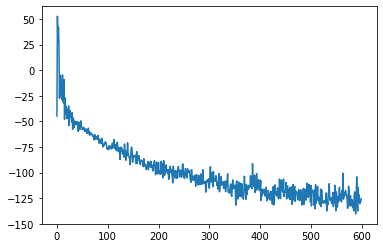

In [13]:
plt.plot(loss_history)

In [14]:
with torch.no_grad():
    zs = model.sample(1000)
    z = zs[-1]
    z = z.detach().numpy()

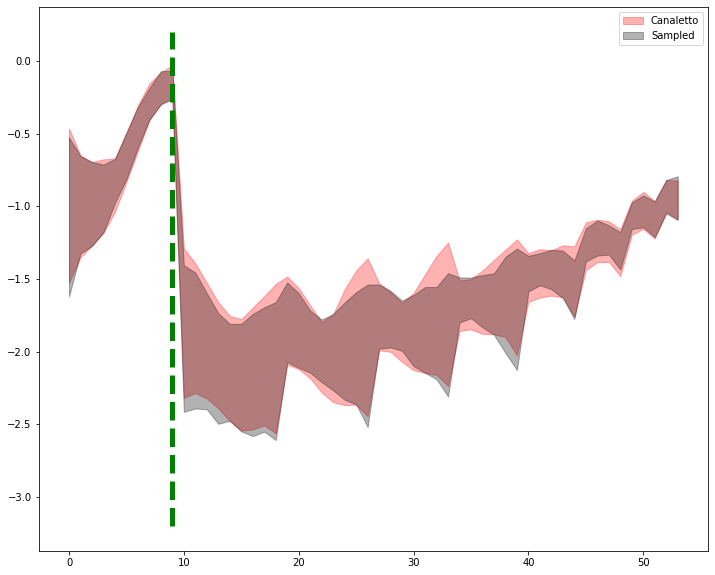

In [15]:
fig = plt.figure(figsize=(12, 10))

plt.fill_between(np.arange(X.shape[1]),\
                 np.percentile(X,2.5,axis=0),np.percentile(X,97.5,axis=0),\
                 alpha=0.3, label="Canaletto",color='red', )

plt.fill_between(np.arange(z.shape[1]),\
                 np.percentile(z,2.5,axis=0),np.percentile(z,97.5,axis=0),\
                 alpha=0.3, label="Sampled",color='k',)
plt.legend()

plt.plot([10 - 1, 10 - 1], [-3.2, 0.2], ls='--', lw=5, c='g')

In [39]:
X_test = data_fake
print(X_test.shape)

X_test = np.log10(X_test[:, :-1])

X_test = torch.Tensor(X_test)
print(X_test.shape)

zs, prior_logprob, log_det = model(X_test)

logprob_follower = prior_logprob + log_det

(2, 55)
torch.Size([2, 54])


In [40]:
zs, prior_logprob, log_det = model(X)

logprob_can= prior_logprob + log_det

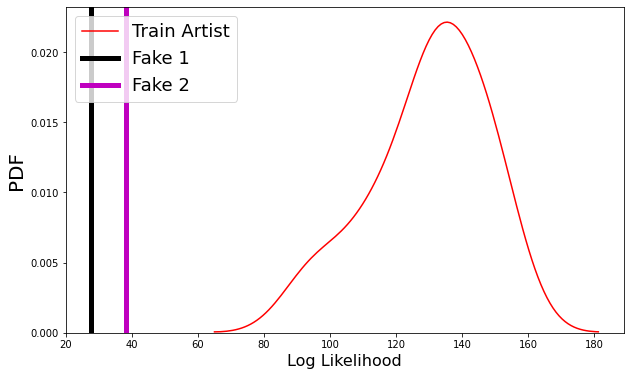

In [54]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(logprob_can.detach().numpy(), color='r',  label='Train Artist')
#sns.kdeplot(logprob_follower.detach().numpy(), color='b',  label='Follower', ax=ax)

plt.axvline(x=logprob_follower[1].detach().numpy(), color='k', lw=5, label='Fake 1')
plt.legend(fontsize=18)

plt.axvline(x=logprob_follower[0].detach().numpy(), color='m', lw=5, label='Fake 2')
plt.legend(fontsize=18)

ax.set_xlabel('Log Likelihood', fontsize=16)
ax.set_ylabel('PDF', fontsize=20)


f.savefig('Fake_lissitzki.pdf')

In [ ]:
new_df = pd.read_csv('/Users/ioanaciuca/Desktop/hephaestusaiLight/cache/canaletto_test/reduced_l_scattering_fixed_pix_0_25mm10_4_2048_df_rgb0.csv')

In [ ]:
new_df

In [ ]:
df_new = new_df[new_df['class_labels'] == 1]
df_new



feat_data_new = df_new.drop(['class_labels', 'target_names', 'img_names'], axis=1)


data_new = feat_data_new.to_numpy()


In [ ]:
new_df

In [ ]:
X_new = data_new
print(X_new.shape)


In [ ]:
data_new

In [ ]:

X_new = np.log10(X_new[:, :-1])

X_new = torch.Tensor(X_new)
print(X_new.shape)

zs, prior_logprob, log_det = model(X_new)

logprob_new = prior_logprob + log_det

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(logprob_can.detach().numpy(), color='g', lw=2.0, label='Train Canaletto', ax=ax)
ax.axvline(x=logprob_new.detach().numpy()[0], color='r', lw=3.5, label='Canaletto test')
ax.axvline(x=logprob_new.detach().numpy()[1], color='m', lw=3.5, label='Hidden artwork')

sns.kdeplot(logprob_follower.detach().numpy(), color='b', lw=2.0,  label='Follower', ax=ax)
plt.legend(fontsize=18)

plt.xlabel('Log Likelihood', fontsize=20)
plt.ylabel('PDF', fontsize=20)

plt.savefig('hidden.png', dpi = 200)

In [ ]:
logprob_new[1]


In [ ]:
X.shape

In [ ]:
logprob_test = max(logprob_follower)
print(logprob_test)

In [ ]:
n_samples = 10000

with torch.no_grad():
    zs = model.sample(n_samples)
    z = zs[-1]
    z = z.detach().numpy()

In [ ]:
zs, prior_logprob, log_det = model(torch.Tensor(z))

logprob_samples = prior_logprob + log_det

In [ ]:
plt.hist(logprob_samples.detach().numpy())

In [ ]:
k = 0

for i in logprob_samples:
    if i < logprob_test.item():
        k = k + 1

In [ ]:
k

In [ ]:
prob = (k/ n_samples) 
prob

In [ ]:
df_follower

In [ ]:
ss = logprob_follower.detach().numpy()

idx =np.where(ss == max(ss))[0]
idx

In [ ]:
df_follower.iloc[2]

In [ ]:
df_copy = df.copy()

for i in range(len(df_copy)):
    
    if df_copy['target_names'][i] == "Not_canaletto":
        df_copy['class_labels'][i] = 0

df_copy

df_copy.to_csv('/Users/ioanaciuca/Desktop/hephaestusaiLight/cache/Canaletto/reduced_l_scattering_fixed_pix_0_25mm10_4_2048_df_rgb0.csv', index=False)

In [ ]:
from astropy.stats import bayesian_blocks as bb


fig = plt.figure(figsize=(8, 8))

edges= bb(logprob.detach().numpy(), fitness='events', p0=0.001)
plt.hist(logprob.detach().numpy(), bins=edges, density=True, alpha=1.0, color='r', histtype='step', lw=2, label='Train Canaletto')


edges1= bb(logprob1.detach().numpy(), fitness='events', p0=0.001)
plt.hist(logprob1.detach().numpy(), bins=edges1, density=True, alpha=1.0, color='b', histtype='step', lw=2, label='Follower')

edges2= bb(logprob2.detach().numpy(), fitness='events', p0=0.001)
plt.hist(logprob2.detach().numpy(), bins=edges2, density=True, alpha=1.0, color='m', histtype='step', lw=2, label='Test Canaletto')






plt.legend(fontsize=16)

In [ ]:
def plot_scattering_estimates(df):

    df_not_artist = df[df["class_labels"] == 1]
    df_artist = df[df["class_labels"] == 0]

    feat_data_not_artist = df_not_artist.drop(
        ["class_labels", "target_names", "img_names"], axis=1
    )
    feat_data_artist = df_artist.drop(
        ["class_labels", "target_names", "img_names"], axis=1
    )

    data_not_artist = feat_data_not_artist.to_numpy()
    data_artist = feat_data_artist.to_numpy()

    # -------------------------------------------------------------------------------------------------------
    # restore coefficients
    scattering_coeff_array_not_artist = data_not_artist
    scattering_coeff_array_not_artist = np.log10(scattering_coeff_array_not_artist)
    # plot 68, 95 confidence level

    scattering_coeff_array_artist = data_artist
    scattering_coeff_array_artist = np.log10(scattering_coeff_array_artist)

    fig = plt.figure(figsize=(10, 8))

    plt.fill_between(
        np.arange(scattering_coeff_array_not_artist.shape[1]),
        np.percentile(scattering_coeff_array_not_artist, 2.5, axis=0),
        np.percentile(scattering_coeff_array_not_artist, 97.5, axis=0),
        alpha=0.5,
        label="Not" + str('artist'),
        color="blue",
    )

    plt.fill_between(
        np.arange(scattering_coeff_array_artist.shape[1]),
        np.percentile(scattering_coeff_array_artist, 2.5, axis=0),
        np.percentile(scattering_coeff_array_artist, 97.5, axis=0),
        alpha=0.5,
        label=str('artist'),
        color="m",
    )

    # plot delimiter
    # plt.plot(
    #     [self.config["J"] - 1, self.config["J"] - 1], [-3.2, 0.2], ls="--", lw=5, color="black"
    # )

    plt.plot([9, 9], [-3.2, 0.2], ls='--', color='g', lw=5)
    plt.text(0, -0.1, "Strokes")
    plt.text(11.0, -0.1, "Clustering of Strokes")
    plt.xlim([-5, len(df.iloc[0, :]) + 5])

    plt.ylabel("Estimate")
    plt.xlabel("Statistical Descriptors")
    plt.legend(loc=4)

    plt.show()

In [ ]:
plot_scattering_estimates(df_test)

In [ ]:
df_copy.shape

In [ ]:
from alibi.explainers import KernelShap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
target = df.class_labels.to_numpy() #class labels

target_names = df.target_names.to_list() #name
feat_data = df.drop(['class_labels', 'target_names', 'img_names'], axis=1)
feature_names  = feat_data.columns.to_list()

data = feat_data.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.7, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)



In [ ]:
df.head(20)

In [ ]:
data

In [ ]:
y_test

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF
clf =GaussianProcessClassifier(1*Matern(2))
clf.fit(X_train_norm, y_train)
pred = clf.predict(X_test_norm)
pred

In [ ]:
y_test

In [ ]:
np.random.seed(0)


y_pred = clf.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)
title = 'Confusion matrix for GP Classifier'
disp = plot_confusion_matrix(clf, 
                             X_test_norm, 
                             y_test,
                             #display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None
                            )
disp.ax_.set_title(title)

In [ ]:

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
title = 'Confusion matrix for GP Classifier'
disp = plot_confusion_matrix(clf, 
                             X_train_norm, 
                             y_train,
       
                             cmap=plt.cm.Blues,
                             normalize=None
                            )
disp.ax_.set_title(title)

In [ ]:
y_train

In [ ]:
y_train_norm

In [ ]:
import os
import sys
import itertools
sys.path.append('/Users/ioanaciuca/Desktop/Normalizing_flows/DeepSpectra/')

import torch.optim as optim

from nflib.spline_flows import NSF_CL
from nflib.flows import (
    AffineConstantFlow,
    ActNorm,
    Invertible1x1Conv,
    NormalizingFlow,
    NormalizingFlowModel,
)

device='cpu'

dim = X.shape[-1]
print('New dim after adding the labels is', dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 1
hidden_dim = 16 #50 dims here... probs neeed to increase


flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

#if torch.cuda.device_count() >1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#assume this is de facto
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))


batch_size=20

oom = False
try:
    model, loss_history = run_model(batch_size)

except RuntimeError: # Out of memory
    oom = True
    print('Error!')

if oom:
    for _ in range(batch_size):
        model, loss_history = run_model(1)

> Real NVP stuff

In [ ]:
#define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
device = torch.device("cpu")
num_neurons = 32

# input dimension
dim_in = X.shape[-1]

nets = lambda: nn.Sequential(nn.Linear(dim_in, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, dim_in), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim_in, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, dim_in))

# define mask
num_layers = 10
masks = []
for i in range(num_layers):
    mask_layer = np.random.randint(2,size=(dim_in))
    masks.append(mask_layer)
    masks.append(1-mask_layer)
masks = torch.from_numpy(np.array(masks).astype(np.float32))
masks.to(device)

# set prior
prior = distributions.MultivariateNormal(torch.zeros(dim_in, device=device),\
                                         torch.eye(dim_in, device=device))

# intiate flow
flow = RealNVP(nets, nett, masks, prior)

num_epochs = 100
batch_size = 20

# break into batches
nsamples = X.shape[0]
nbatches = nsamples // batch_size

# optimizing flow models
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-5)
print("number of params: ", sum(p.numel() for p in flow.parameters()))

# train the network
# put here the loss
loss_history = []
for e in range(num_epochs):

    # randomly permute the data
    perm = torch.randperm(nsamples)

    # For each batch, calculate the gradient with respect to the loss and take
    # one step.
    for i in range(nbatches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        loss = -flow.log_prob(X[idx]).mean()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_history.append(loss)

    # the average loss.
    if e % 10 == 0:
        print('iter %s:' % e, 'loss = %.3f' % loss)
        
plt.plot(loss_history, label = 'Negative log likelihood')
plt.title("Model Loss vs Training Iteration")
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
dim_in = 54

base_mu, base_cov = torch.zeros(dim_in), torch.eye(dim_in)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(1000,))

samples = flow.sample(Z)

samples = samples.detach().numpy()

plt.fill_between(np.arange(samples.shape[1]),\
                 np.percentile(X,2.5,axis=0),np.percentile(samples,97.5,axis=0),\
                 alpha=0.3, label="Canaletto",color='blue')

# plot delimiter
plt.plot([10-1,10-1], [-3.2,0.2], ls="--", lw=5, color="black")
plt.text(-11.,-0.1, "Strokes")
plt.text(11.,-0.1, "Clustering of Strokes")
plt.xlim([-15,60])